<a href="https://colab.research.google.com/github/ToshikiNakamura0412/my_ipynb/blob/master/preprosess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

feature num: 133


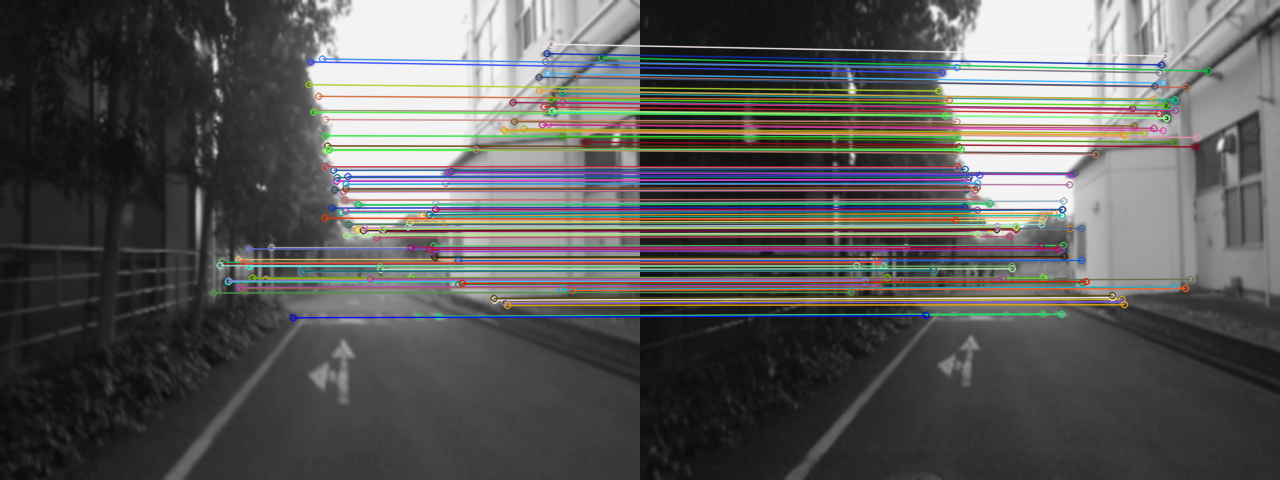

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# ===
# Preprocess
# ===
# Read as Gray
img1 = cv2.imread("image_87_qu.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("image_87_ref.png", cv2.IMREAD_GRAYSCALE)
# Normalization
img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX)
img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX)
# Resize
img1 = cv2.resize(img1, (640, 480))
img2 = cv2.resize(img2, (640, 480))
# GaussianBlur
img1 = cv2.GaussianBlur(img1, (5, 5), 0)
img2 = cv2.GaussianBlur(img2, (5, 5), 0)

# ===
# Feature Matching
# ===
# feature = cv2.ORB_create()
feature = cv2.AKAZE_create()
kp1, des1 = feature.detectAndCompute(img1, None)
kp2, des2 = feature.detectAndCompute(img2, None)

FLANN_INDEX_LSH = 6
index_params= dict(algorithm         = FLANN_INDEX_LSH,
                  table_number      = 6,
                  key_size          = 12,
                  multi_probe_level = 1)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k = 2)

# ===
# Ratio Test
# ===
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# ===
# RANSAC
# ===
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC, 3, 0.99)
matches_mask = mask.ravel().tolist()
ransac_matches = []
for i in range(len(matches_mask)):
    if matches_mask[i] == 1:
        ransac_matches.append(good_matches[i])

# ===
# Visualization
# ===
img3 = cv2.drawMatches(img1, kp1, img2, kp2, ransac_matches, None, flags=2)
print(f"feature num: {len(ransac_matches)}")
cv2_imshow(img3)